In [19]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import time
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the training, validation, and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 training dataset without transforms
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=None)

# Split into training and validation sets
train_size = int(0.9 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset_full, valset_full = torch.utils.data.random_split(trainset_full, [train_size, val_size])

# Custom Dataset to apply transforms after splitting
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

# Apply transforms to the datasets
trainset = CIFAR10Dataset(trainset_full, transform=transform_train)
valset = CIFAR10Dataset(valset_full, transform=transform_test)

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                        shuffle=False, num_workers=2)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Define the training function
def train_model(model, model_name, epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in valloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss = val_running_loss / len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)

        scheduler.step()
        print(f"[{model_name}] Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    print(f'Finished Training {model_name}')

    return train_losses, train_accuracies, val_losses, val_accuracies


def evaluate_model(model, model_name):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy of {model_name} on the 10000 test images: {test_accuracy:.2f}%')
    return test_accuracy

Files already downloaded and verified
Files already downloaded and verified


In [20]:

def get_resnet18():
    resnet18 = models.resnet18(pretrained=False)
    resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    resnet18.maxpool = nn.Identity()  
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
    return resnet18

resnet18 = get_resnet18()
print("Training ResNet-18 on CIFAR-10")
num_epochs = 10
train_losses_resnet18, train_accuracies_resnet18, val_losses_resnet18, val_accuracies_resnet18 = train_model(
    resnet18, "ResNet-18", epochs=num_epochs)
test_accuracy_resnet18 = evaluate_model(resnet18, "ResNet-18")


Training ResNet-18 on CIFAR-10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[ResNet-18] Epoch [1/10], Train Loss: 1.8879, Train Acc: 31.41%, Val Loss: 1.5512, Val Acc: 44.06%
[ResNet-18] Epoch [2/10], Train Loss: 1.3872, Train Acc: 49.02%, Val Loss: 1.3876, Val Acc: 49.26%
[ResNet-18] Epoch [3/10], Train Loss: 1.1046, Train Acc: 60.25%, Val Loss: 1.1099, Val Acc: 61.62%
[ResNet-18] Epoch [4/10], Train Loss: 0.9193, Train Acc: 67.61%, Val Loss: 0.8108, Val Acc: 71.58%
[ResNet-18] Epoch [5/10], Train Loss: 0.7807, Train Acc: 72.57%, Val Loss: 0.8300, Val Acc: 71.76%
[ResNet-18] Epoch [6/10], Train Loss: 0.6596, Train Acc: 77.10%, Val Loss: 0.8230, Val Acc: 72.18%
[ResNet-18] Epoch [7/10], Train Loss: 0.5908, Train Acc: 79.42%, Val Loss: 0.6353, Val Acc: 78.26%
[ResNet-18] Epoch [8/10], Train Loss: 0.5489, Train Acc: 81.20%, Val Loss: 0.7402, Val Acc: 76.46%
[ResNet-18] Epoch [9/10], Train Loss: 0.5185, Train Acc: 82.19%, Val Loss: 0.6937, Val Acc: 76.20%
[ResNet-18] Epoch [10/10], Train Loss: 0.4918, Train Acc: 83.12%, Val Loss: 0.9460, Val Acc: 69.94%
Finished 

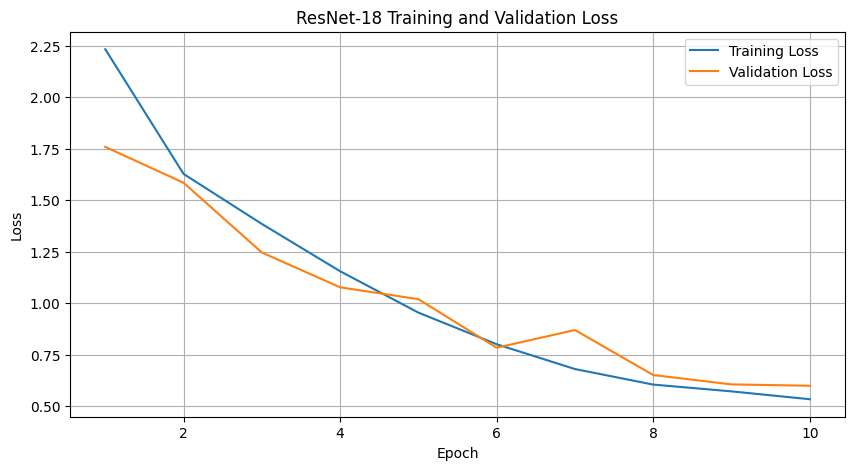

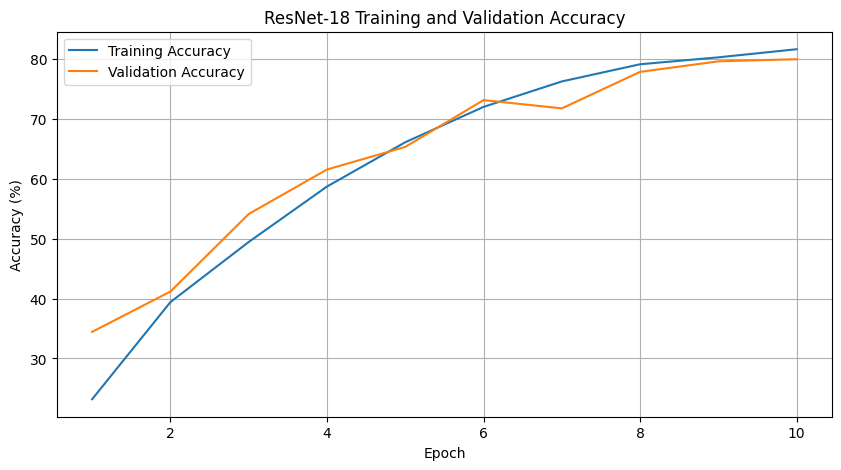

In [8]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses_resnet18, label='Training Loss')
plt.plot(epochs_range, val_losses_resnet18, label='Validation Loss')
plt.title('ResNet-18 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies_resnet18, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies_resnet18, label='Validation Accuracy')
plt.title('ResNet-18 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Adjusting ResNet-34 for CIFAR-10
def get_resnet34():
    resnet34 = models.resnet34(pretrained=False)
    resnet34.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    resnet34.maxpool = nn.Identity()  
    resnet34.fc = nn.Linear(resnet34.fc.in_features, 10)
    return resnet34
# Clear CUDA cache
torch.cuda.empty_cache()
# Training and Evaluating ResNet-34
resnet34 = get_resnet34()
print("\nTraining ResNet-34 on CIFAR-10")
train_losses_resnet34, train_accuracies_resnet34, val_losses_resnet34, val_accuracies_resnet34 = train_model(
    resnet34, "ResNet-34", epochs=num_epochs)
test_accuracy_resnet34 = evaluate_model(resnet34, "ResNet-34")



Training ResNet-34 on CIFAR-10
[ResNet-34] Epoch [1/10], Train Loss: 2.2236, Train Acc: 19.28%, Val Loss: 1.9960, Val Acc: 25.72%
[ResNet-34] Epoch [2/10], Train Loss: 1.7184, Train Acc: 34.62%, Val Loss: 1.6833, Val Acc: 38.26%
[ResNet-34] Epoch [3/10], Train Loss: 1.5083, Train Acc: 43.42%, Val Loss: 1.4379, Val Acc: 47.24%
[ResNet-34] Epoch [4/10], Train Loss: 1.3041, Train Acc: 52.05%, Val Loss: 1.3932, Val Acc: 50.64%
[ResNet-34] Epoch [5/10], Train Loss: 1.1297, Train Acc: 59.47%, Val Loss: 1.0988, Val Acc: 61.96%
[ResNet-34] Epoch [6/10], Train Loss: 0.9817, Train Acc: 65.14%, Val Loss: 1.2169, Val Acc: 59.08%
[ResNet-34] Epoch [7/10], Train Loss: 0.8609, Train Acc: 69.62%, Val Loss: 0.9968, Val Acc: 66.86%
[ResNet-34] Epoch [8/10], Train Loss: 0.7577, Train Acc: 73.68%, Val Loss: 0.8162, Val Acc: 71.38%
[ResNet-34] Epoch [9/10], Train Loss: 0.6746, Train Acc: 76.71%, Val Loss: 0.7639, Val Acc: 73.88%
[ResNet-34] Epoch [10/10], Train Loss: 0.6045, Train Acc: 79.23%, Val Loss: 0

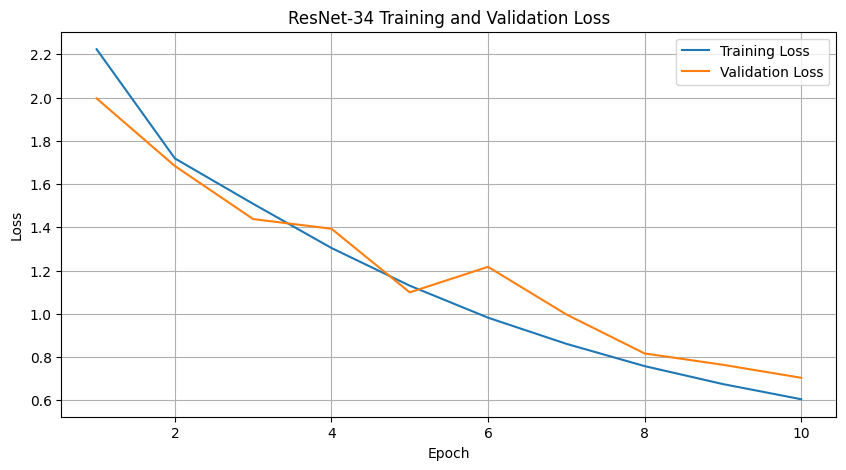

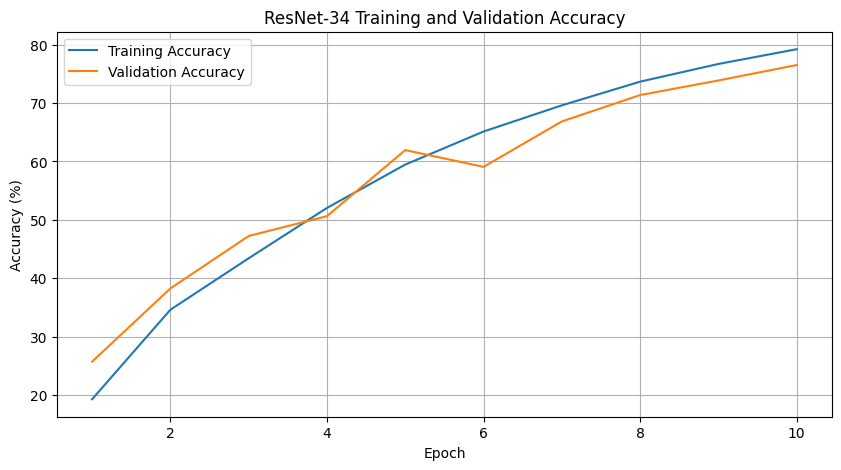

In [10]:
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses_resnet34, label='Training Loss')
plt.plot(epochs_range, val_losses_resnet34, label='Validation Loss')
plt.title('ResNet-34 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies_resnet34, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies_resnet34, label='Validation Accuracy')
plt.title('ResNet-34 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Adjusting ResNet-50 for CIFAR-10
def get_resnet50():
    resnet50 = models.resnet50(pretrained=False)
    resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    resnet50.maxpool = nn.Identity()  # Remove the max-pooling layer
    resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
    return resnet50
torch.cuda.empty_cache()

resnet50 = get_resnet50()
print("\nTraining ResNet-50 on CIFAR-10")
train_losses_resnet50, train_accuracies_resnet50, val_losses_resnet50, val_accuracies_resnet50 = train_model(
    resnet50, "ResNet-50", epochs=num_epochs)
test_accuracy_resnet50 = evaluate_model(resnet50, "ResNet-50")


Training ResNet-50 on CIFAR-10
[ResNet-50] Epoch [1/10], Train Loss: 2.9898, Train Acc: 12.85%, Val Loss: 2.2283, Val Acc: 16.88%
[ResNet-50] Epoch [2/10], Train Loss: 2.0020, Train Acc: 20.95%, Val Loss: 1.9001, Val Acc: 24.50%
[ResNet-50] Epoch [3/10], Train Loss: 1.7850, Train Acc: 29.30%, Val Loss: 1.6537, Val Acc: 36.92%
[ResNet-50] Epoch [4/10], Train Loss: 1.5124, Train Acc: 43.32%, Val Loss: 1.4930, Val Acc: 47.38%
[ResNet-50] Epoch [5/10], Train Loss: 1.3004, Train Acc: 52.34%, Val Loss: 1.3743, Val Acc: 51.80%
[ResNet-50] Epoch [6/10], Train Loss: 1.1568, Train Acc: 58.23%, Val Loss: 1.1194, Val Acc: 59.36%
[ResNet-50] Epoch [7/10], Train Loss: 1.0576, Train Acc: 62.16%, Val Loss: 1.2288, Val Acc: 57.74%
[ResNet-50] Epoch [8/10], Train Loss: 0.9572, Train Acc: 65.85%, Val Loss: 1.1483, Val Acc: 59.92%
[ResNet-50] Epoch [9/10], Train Loss: 0.8816, Train Acc: 68.62%, Val Loss: 1.0314, Val Acc: 66.50%
[ResNet-50] Epoch [10/10], Train Loss: 0.8006, Train Acc: 71.89%, Val Loss: 1

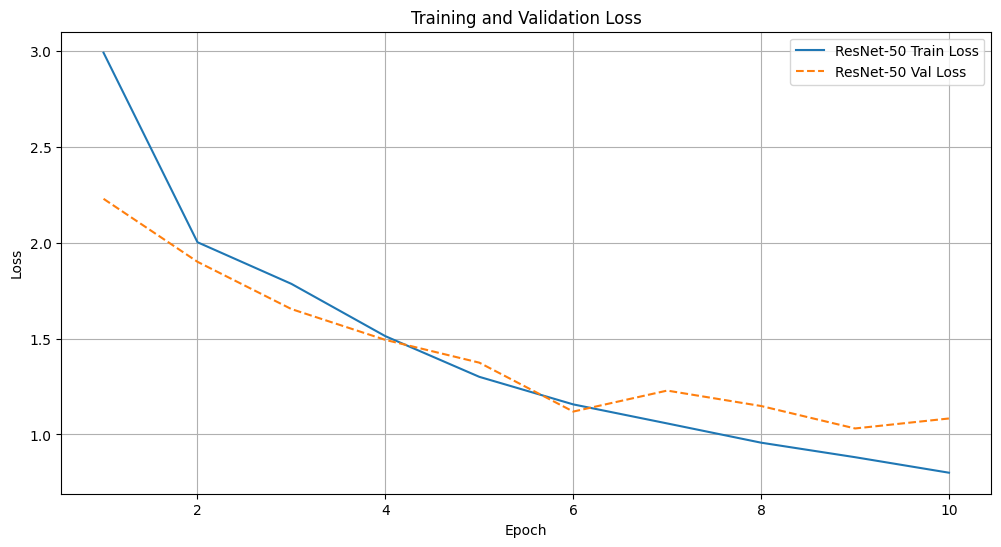

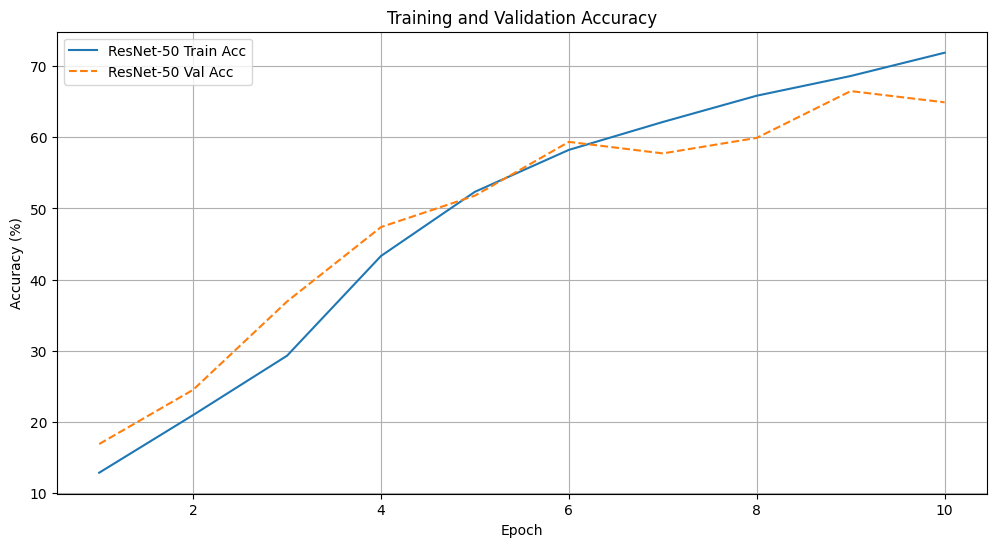

In [12]:
plt.figure(figsize=(12,6))
plt.plot(epochs_range, train_losses_resnet50, label='ResNet-50 Train Loss')
plt.plot(epochs_range, val_losses_resnet50, label='ResNet-50 Val Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(epochs_range, train_accuracies_resnet50, label='ResNet-50 Train Acc')
plt.plot(epochs_range, val_accuracies_resnet50, label='ResNet-50 Val Acc', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Adjusting MobileNet for CIFAR-10
def get_mobilenet_v2():

    mobilenet_v2 = models.mobilenet_v2(weights=None)

    mobilenet_v2.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)

    mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 10)

    return mobilenet_v2

torch.cuda.empty_cache()

# Training and Evaluating MobileNet
mobilenet_v2 = get_mobilenet_v2()
print("\nTraining MobileNet on CIFAR-10")
train_losses_mobilenet, train_accuracies_mobilenet, val_losses_mobilenet, val_accuracies_mobilenet = train_model(
    mobilenet_v2, "MobileNet", epochs=10)
test_accuracy_mobilenet = evaluate_model(mobilenet_v2, "MobileNet")



Training MobileNet on CIFAR-10
[MobileNet] Epoch [1/10], Train Loss: 1.9657, Train Acc: 30.57%, Val Loss: 1.6161, Val Acc: 40.60%
[MobileNet] Epoch [2/10], Train Loss: 1.5263, Train Acc: 43.64%, Val Loss: 1.4519, Val Acc: 46.94%
[MobileNet] Epoch [3/10], Train Loss: 1.3342, Train Acc: 51.66%, Val Loss: 1.2512, Val Acc: 54.82%
[MobileNet] Epoch [4/10], Train Loss: 1.1761, Train Acc: 58.05%, Val Loss: 1.3158, Val Acc: 54.04%
[MobileNet] Epoch [5/10], Train Loss: 1.0186, Train Acc: 64.10%, Val Loss: 1.1845, Val Acc: 58.88%
[MobileNet] Epoch [6/10], Train Loss: 0.9220, Train Acc: 67.80%, Val Loss: 1.0028, Val Acc: 65.60%
[MobileNet] Epoch [7/10], Train Loss: 0.8539, Train Acc: 70.60%, Val Loss: 0.8106, Val Acc: 72.84%
[MobileNet] Epoch [8/10], Train Loss: 0.8075, Train Acc: 72.26%, Val Loss: 0.7394, Val Acc: 73.82%
[MobileNet] Epoch [9/10], Train Loss: 0.7844, Train Acc: 72.99%, Val Loss: 1.1314, Val Acc: 62.34%
[MobileNet] Epoch [10/10], Train Loss: 0.7658, Train Acc: 73.82%, Val Loss: 0

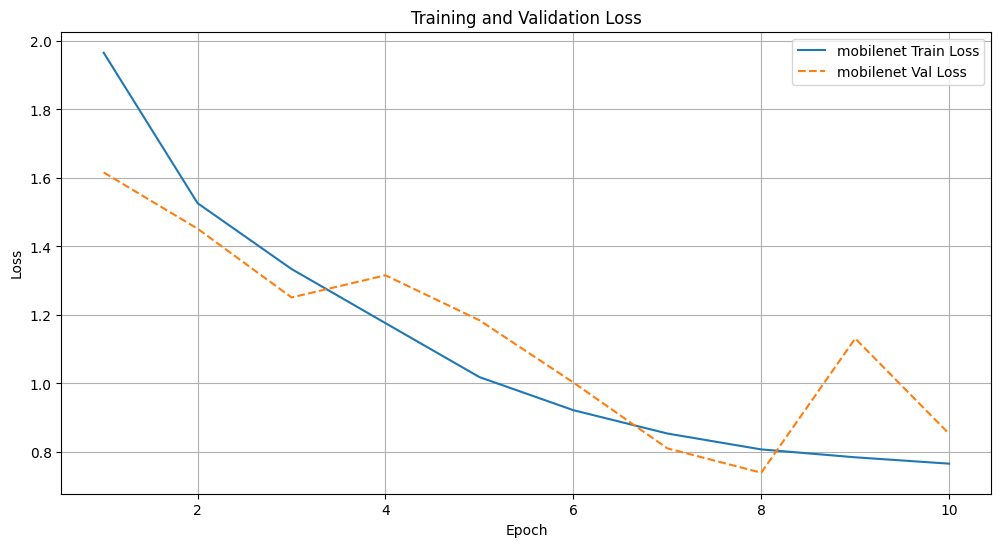

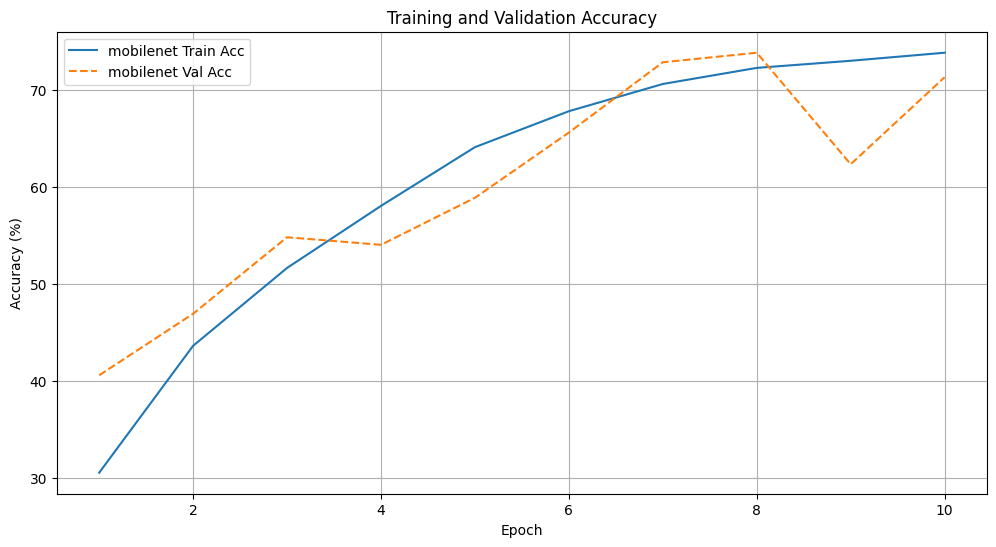

In [14]:
num_epochs = 10
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12,6))
plt.plot(epochs_range, train_losses_mobilenet, label='mobilenet Train Loss')
plt.plot(epochs_range, val_losses_mobilenet, label='mobilenet Val Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(epochs_range, train_accuracies_mobilenet, label='mobilenet Train Acc')
plt.plot(epochs_range, val_accuracies_mobilenet, label='mobilenet Val Acc', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def get_alexnet():

    alexnet = models.alexnet(weights=None)

    alexnet.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)

    return alexnet

alexnet = get_alexnet()
print("\nTraining AlexNet on CIFAR-10 (Training from Scratch)")
train_losses_alexnet, train_accuracies_alexnet, val_losses_alexnet, val_accuracies_alexnet = train_model(
    alexnet, "AlexNet", epochs=num_epochs)
test_accuracy_alexnet = evaluate_model(alexnet, "AlexNet")


Training AlexNet on CIFAR-10 (Training from Scratch)
[AlexNet] Epoch [1/10], Train Loss: 2.2277, Train Acc: 14.35%, Val Loss: 2.0120, Val Acc: 22.06%
[AlexNet] Epoch [2/10], Train Loss: 2.0143, Train Acc: 22.94%, Val Loss: 2.0871, Val Acc: 23.28%
[AlexNet] Epoch [3/10], Train Loss: 1.9840, Train Acc: 23.63%, Val Loss: 1.9243, Val Acc: 26.16%
[AlexNet] Epoch [4/10], Train Loss: 1.9191, Train Acc: 27.12%, Val Loss: 1.8683, Val Acc: 28.64%
[AlexNet] Epoch [5/10], Train Loss: 1.8904, Train Acc: 28.17%, Val Loss: 1.7863, Val Acc: 29.32%
[AlexNet] Epoch [6/10], Train Loss: 1.9075, Train Acc: 27.34%, Val Loss: 1.8382, Val Acc: 30.20%
[AlexNet] Epoch [7/10], Train Loss: 1.8777, Train Acc: 28.55%, Val Loss: 1.8703, Val Acc: 30.72%
[AlexNet] Epoch [8/10], Train Loss: 1.8590, Train Acc: 29.27%, Val Loss: 1.8895, Val Acc: 30.64%
[AlexNet] Epoch [9/10], Train Loss: 1.8240, Train Acc: 30.77%, Val Loss: 1.7679, Val Acc: 33.64%
[AlexNet] Epoch [10/10], Train Loss: 1.8119, Train Acc: 31.71%, Val Loss:

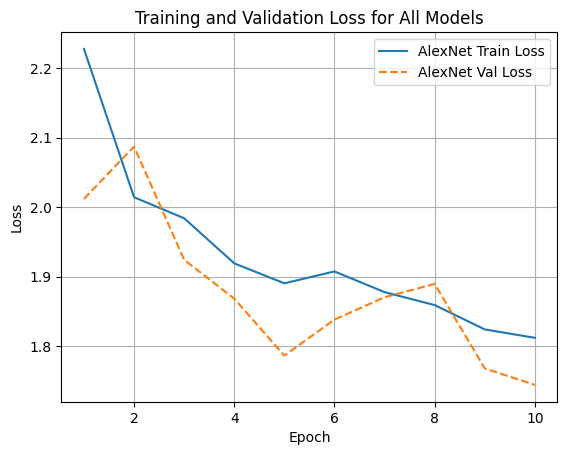

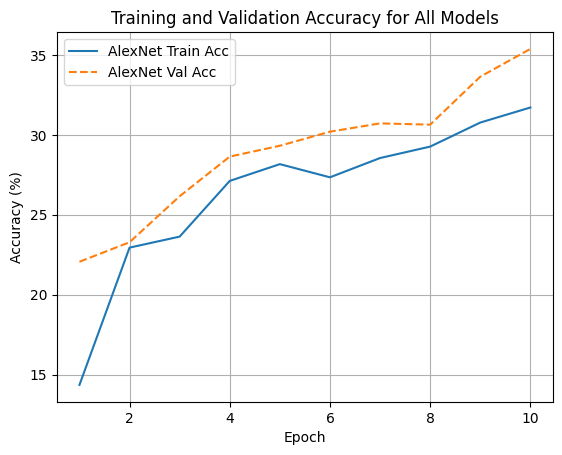

In [18]:
plt.plot(epochs_range, train_losses_alexnet, label='AlexNet Train Loss')
plt.plot(epochs_range, val_losses_alexnet, label='AlexNet Val Loss', linestyle='--')

plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs_range, train_accuracies_alexnet, label='AlexNet Train Acc',)
plt.plot(epochs_range, val_accuracies_alexnet, label='AlexNet Val Acc', linestyle='--')

plt.title('Training and Validation Accuracy for All Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()